# Driverless AI for AutoML

This notebook is intended to help you get started with AutoML in the H2O AI Cloud using python.

* **Product Documentation:** https://docs.h2o.ai/driverless-ai/1-10-lts/docs/userguide/index.html
* **Python Documentation:** https://docs.h2o.ai/driverless-ai/pyclient/docs/html/index.html
* **Additional Tutorials:** https://github.com/h2oai/driverlessai-tutorials/tree/master/dai_python_client

In [1]:
import h2o_engine_manager

import pandas as pd
import numpy as np

## Securely connect

In [ ]:
engine_manager = h2o_engine_manager.login()

## Connect to Driverless AI
We'll create a connection object called dai that we will use to interact with the engine.

In [ ]:
dai_engine = engine_manager.dai_engine_client.create_engine(
    display_name="My test engine",
)

dai_engine.wait()

In [ ]:
dai = dai_engine.connect()

### Visit the DAI URL
You must click the link below if you would like to use the DAI UI anywhere else in this notebook.

In [ ]:
print(dai_engine.login_url)

In [ ]:
dai.server.version

## Documentation
You can get links to the home page and search the documentation from the python client any time you want to know more about a specific DAI functionality. 

In [7]:
dai.server.docs("autoviz")

'https://steam.cloud.h2o.ai:443/proxy/driverless/3286/docs/userguide/search.html?q=autoviz'

## Data
Various methods for loading, interacting with, and modifiying data wihthin Driverless AI.

### List Available Connectors
View all ways you are allowed to add data to DAI on this instace - to enable more connectors update the `config.toml` file <br/><br/>
**Note:** Interactions with Data Recipes is not yet available so these connectors are not shown

In [8]:
dai.connectors.list()

['upload', 'file', 's3', 'recipe_file', 'recipe_url']

### List Existing Datasets

In [9]:
# Get a link to view all datasets in the UI
dai.datasets.gui()

print()

# List all datasets    
print(dai.datasets.list(start_index=0, count=4))

print()

# pretty print
for d in dai.datasets.list(start_index=0, count=4):
    print(type(d), d.key, d.name)


    | Type   | Key   | Name
----+--------+-------+--------



### Upload and Download Data
You can upload data using any method that is enabled on your system. Here we will show:
* Add data from a public s3 link
* Download a dataset
* Upload data from your local machine
* Rename a dataset
* Upload using the JDBC connector

In [10]:
telco_churn = dai.datasets.create(data="https://h2o-internal-release.s3-us-west-2.amazonaws.com/data/Splunk/churn.csv", 
                                  data_source="s3", 
                                  name="Telco_Churn",
                                  force=True
                                 )

Complete 100.00% - [4/4] Computed stats for column Churn?


In [11]:
local_file_path = telco_churn.download("./", overwrite=True)

Downloaded 'churn.csv.1657067059.647558.csv'


In [12]:
telco_churn2 = dai.datasets.create(local_file_path, name="Telco_Churn_Duplicate")

Complete 100.00% - [4/4] Computed stats for column Churn?


In [13]:
print("Old Name:", telco_churn2.name)

telco_churn2.rename("Fancy New Name")

print("New Name:", telco_churn2.name)

Old Name: Telco_Churn_Duplicate
New Name: Fancy New Name


In [14]:
# Upload using the JDBC connector
# Note 1: You must have JDBC in the list of available connectors
# Note 2: Appropriate JARS must be on the DAI server

jdbc_config = {
    'jdbc_jar': '/data/postgresql-42.2.9.jar',
    'jdbc_driver': 'org.postgresql.Driver',
    'jdbc_url': 'jdbc:postgresql://mr-dl2:5432/h2oaidev',
    'jdbc_username': 'h2oaitester',
    'jdbc_password': 'h2oaitesterreadonly'
}

# jdbc_ds = dai.datasets.create(   
#     data='SELECT * FROM creditcardtrain',
#     data_source='jdbc',
#     data_source_config=jdbc_config,
#     name='beta_jdbc_test'
# )

### Explore the Dataset
* View the column names
* View the data shape
* View the first and last rows

In [15]:
print(telco_churn.key, "|", telco_churn.name)
print("\nColumns:", telco_churn.columns)
print('\nShape:', telco_churn.shape)

f956fdfa-fcc1-11ec-88b7-66b02643127c | Telco_Churn

Columns: ['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Shape: (3333, 21)


In [16]:
telco_churn.head()

State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10,3,2.7,1,False.
OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.
NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,False.
OH,84,408,375-9999,yes,no,0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [17]:
telco_churn.tail()

State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False.
WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False.
RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False.
CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5,10,1.35,2,False.
TN,74,415,400-4344,no,yes,25,234.4,113,39.85,265.9,82,22.6,241.4,77,10.86,13.7,4,3.7,0,False.


### Explore the Columns
* View column summaries
* Update the datatype to be used in modeling

In [18]:
# View all column summaries
# print(telco_churn.column_summaries())

In [19]:
print(telco_churn.column_summaries(["Area Code"]))

--- Area Code ---

 408|██████████
    |████████████████████
 510|██████████

Data Type: int
Logical Types: []
Datetime Format: 
Count: 3333
Missing: 0
Mean: 437
SD: 42.4
Min: 408
Max: 510
Unique: 3
Freq: 1655



In [20]:
# Force a numeric column to only be used as a category
telco_churn.set_logical_types({'Area Code': ['categorical']})
print(telco_churn.column_summaries()["Area Code"])

--- Area Code ---

 408|██████████
    |████████████████████
 510|██████████

Data Type: int
Logical Types: ['categorical']
Datetime Format: 
Count: 3333
Missing: 0
Mean: 437
SD: 42.4
Min: 408
Max: 510
Unique: 3
Freq: 1655


### Split a Dataset
The split function returns a dictionary of two datasets so you can easily pass them to the experiments

In [21]:
telco_churn_split = telco_churn.split_to_train_test(
    train_size=0.8, 
    train_name='telco_churn_train', 
    test_name='telco_churn_test', 
    target_column= "Churn?", # Beta users with client from before March 15th use target_col
    seed=42
)

Complete


In [22]:
telco_churn_split

{'train_dataset': <class 'Dataset'> 0cb68884-fcc2-11ec-88b7-66b02643127c telco_churn_train,
 'test_dataset': <class 'Dataset'> 0cb6a9c2-fcc2-11ec-88b7-66b02643127c telco_churn_test}

In [23]:
for k, v in telco_churn_split.items():
    print(k, "\t" ,v.key, v.name)

train_dataset 	 0cb68884-fcc2-11ec-88b7-66b02643127c telco_churn_train
test_dataset 	 0cb6a9c2-fcc2-11ec-88b7-66b02643127c telco_churn_test


## Recipes
Recipes are components of the ML pipeline such as algorithms, feature transformers, and scores. You can view all availabe recipes and upload new ones to your instance of DAI.

* List all available models
* List any custom transformers
* List all scorers that can be used for binomial classification
* Upload a custom recipe and save it to be tested later

In [24]:
[m.name for m in dai.recipes.models.list()]

['Constant',
 'DecisionTree',
 'FTRL',
 'GLM',
 'ImageAuto',
 'ImbalancedLightGBM',
 'ImbalancedXGBoostGBM',
 'IsolationForestAnomaly',
 'KMeans',
 'KMeansFreq',
 'KMeansOHE',
 'LightGBM',
 'LightGBMDask',
 'RuleFit',
 'TensorFlow',
 'TextALBERT',
 'TextBERT',
 'TextCamemBERT',
 'TextDistilBERT',
 'TextMultilingualBERT',
 'TextRoBERTa',
 'TextXLM',
 'TextXLMRoberta',
 'TextXLNET',
 'TorchGrowNet',
 'TruncSVD',
 'Unsupervised',
 'XGBoostDart',
 'XGBoostDartDask',
 'XGBoostGBM',
 'XGBoostGBMDask',
 'XGBoostRF',
 'XGBoostRFDask',
 'ZeroInflatedLightGBM',
 'ZeroInflatedXGBoost']

In [25]:
[t.name for t in dai.recipes.transformers.list() if t.is_custom ]

[]

In [26]:
[s.name for s in dai.recipes.scorers.list() if s.for_binomial]

['ACCURACY',
 'AUC',
 'AUCPR',
 'F05',
 'F1',
 'F2',
 'GINI',
 'LOGLOSS',
 'MACROAUC',
 'MACROF1',
 'MACROMCC',
 'MCC']

In [27]:
dai.recipes.create("https://github.com/h2oai/driverlessai-recipes/blob/rel-1.8.6/transformers/numeric/sum.py")

Complete 100.00%


In [28]:
[t.name for t in dai.recipes.transformers.list() if t.is_custom ]

['SumTransformer|sum_ef3e7726_content.py']

In [29]:
transformers_to_use = [t for t in dai.recipes.transformers.list() if not t.is_custom or 'Sum' in t.name]

## Modeling
**Notes:** Dictionaries allow you to easily use common settings in your experiments <br/>
**Notes:** Experiments will be `sync` by default meaning they will lock the notebook until they are complete. You can also use `async` versions of the fucntions. With the `async` functions you can use included code below to monthior and experiment as it runs, see logs in real time, and stop it when it is "good enough".

### List Existing Experiments

In [30]:
[e.name for e in dai.experiments.list()]

[]

### Dictionary for a Use Case
We might want to run several experiments with different dial and expert settings. All of these will likely have some things in common, namely details about this specific dataset. We will create a dictionary to use in many experiments.

In [31]:
telco_settings = {
    **telco_churn_split,
    'task': 'classification',
    'target_column': "Churn?", # Beta users with client from before March 15th use target_col
    'scorer': 'F1'
}

### Dictionary for Fast Experiments

There may be several common types of experiments you want to run, and H2O.ai will be creating common experiment settings in dictionaries for easy use. The one below turns off all extra settings such as building pipelines or checking for leakage. It also uses the fastest experiment settings.

In [32]:
fast_settings = {
    'accuracy': 1,
    'time': 1,
    'interpretability': 6,
    'make_python_scoring_pipeline': 'off',
    'make_mojo_scoring_pipeline': 'off',
    'benchmark_mojo_latency': 'off',
    'make_autoreport': False,
    'check_leakage': 'off',
    'check_distribution_shift': 'off'
}

### Search for Settings
There are many expert settings available, you can use the serach functionality to look for names or keywords for settings you may want to use.

In [33]:
dai.experiments.search_expert_settings('imbalanced')

enable_lightgbm_multiclass_balancing | default_value: auto
force_stratified_splits_for_imbalanced_threshold_binary | default_value: 0.01
imbalance_sampling_method | default_value: off
imbalance_sampling_threshold_min_rows_original | default_value: 100000
imbalance_ratio_sampling_threshold | default_value: 5
heavy_imbalance_ratio_sampling_threshold | default_value: 25
imbalance_sampling_number_of_bags | default_value: -1
imbalance_sampling_max_number_of_bags | default_value: 10
imbalance_sampling_max_number_of_bags_feature_evolution | default_value: 3
imbalance_sampling_max_multiple_data_size | default_value: 1.0
imbalance_sampling_target_minority_fraction | default_value: -1.0
imbalance_ratio_notification_threshold | default_value: 2.0


In [34]:
dai.experiments.search_expert_settings('imbalanced', show_description=True )

enable_lightgbm_multiclass_balancing | default_value: auto | LightGBM multiclass balancing
  Whether to enable automatic class weighting for imbalanced multiclass problems. Can make worse probabilities, but improve confusion-matrix based scorers for rare classes without the need to manually calibrate probabilities or fine-tune the label creation process.

force_stratified_splits_for_imbalanced_threshold_binary | default_value: 0.01 | Perform stratified sampling for binary classification if the target is more imbalanced than this.
  Ratio of minority to majority class of the target column beyond which stratified sampling is done for binary classification. Otherwise perform random sampling. Set to 0 to always do random sampling. Set to 1 to always do stratified sampling.

imbalance_sampling_method | default_value: off | Sampling method for imbalanced binary classification problems
  Sampling method for imbalanced binary classification problems. Choices are: "auto": sample both classes as

### Get Recommended Dial Settings

In [35]:
# Get experiment preview with our settings
dai.experiments.preview(
    **telco_settings
)

ACCURACY [7/10]:
- Training data size: *2,666 rows, 20 cols*
- Feature evolution: *[Constant, LightGBM, XGBoostGBM]*, *3-fold CV**, 2 reps*
- Final pipeline: *Blend of up to 2 [Constant, LightGBM, XGBoostGBM] models, each averaged across 3-fold CV splits*

TIME [2/10]:
- Feature evolution: *8 individuals*, up to *10 iterations*
- Early stopping: After *5* iterations of no improvement

INTERPRETABILITY [8/10]:
- Feature pre-pruning strategy: Permutation Importance FS
- Monotonicity constraints: enabled
- Feature engineering search space: [CVCatNumEncode, CVTargetEncode, Frequent, Interactions, NumCatTE, NumToCatWoEMonotonic, NumToCatWoE, Original, Text, WeightOfEvidence]
- Pre-trained PyTorch NLP transformers (without fine-tuning): ['disabled']
- Pre-trained PyTorch NLP models (with fine-tuning): ['disabled']

[Constant, LightGBM, XGBoostGBM] models to train:
- Model and feature tuning: *72*
- Feature evolution: *288*
- Final pipeline: *6*

Estimated runtime: *10 minutes*
Estimated mojo

### Preview Using Our Custom Recipe
Notice that `Sum` has been added to the `Feature engineering search space`

In [36]:
# Get experiment preview with our settings
dai.experiments.preview(
    **telco_settings
    ,transformers=transformers_to_use
)

ACCURACY [7/10]:
- Training data size: *2,666 rows, 20 cols*
- Feature evolution: *[Constant, LightGBM, XGBoostGBM]*, *3-fold CV**, 2 reps*
- Final pipeline: *Blend of up to 2 [Constant, LightGBM, XGBoostGBM] models, each averaged across 3-fold CV splits*

TIME [2/10]:
- Feature evolution: *8 individuals*, up to *10 iterations*
- Early stopping: After *5* iterations of no improvement

INTERPRETABILITY [8/10]:
- Feature pre-pruning strategy: Permutation Importance FS
- Monotonicity constraints: enabled
- Feature engineering search space: [CVCatNumEncode, CVTargetEncode, Frequent, Interactions, NumCatTE, NumToCatWoEMonotonic, NumToCatWoE, Original, Sum, Text, WeightOfEvidence]
- Pre-trained PyTorch NLP transformers (without fine-tuning): ['disabled']
- Pre-trained PyTorch NLP models (with fine-tuning): ['disabled']

[Constant, LightGBM, XGBoostGBM] models to train:
- Model and feature tuning: *72*
- Feature evolution: *288*
- Final pipeline: *6*
- Transformers without MOJO support: *['Su

### Launch an Experiment
We will start by running an async experiment which will immeadiatly free our notebook to run additional commands

In [ ]:
default_baseline = dai.experiments.create_async(
    **telco_settings, 
    name='Fastest Settings', **fast_settings,
    force=True
    # name='Default Baseline', accuracy=7, time=2, interpretability=8
)

### Information on an Experiment

In [ ]:
print("Name:", default_baseline.name)
print("Datasets:", default_baseline.datasets)
print("Target:", default_baseline.settings['target_column']) # beta users from before March 15th use target_col
print("Scorer:", default_baseline.metrics()['scorer'])
print("Task:", default_baseline.settings['task'])
print("Status:", default_baseline.status(verbose=2))
print("Web Page: ", end='')
default_baseline.gui()

### Monitor and Finish the Model Early
Example of how you may want to monitor a running experiment, this will print the currently logs and accuracy metrics. You can also finish a model early if it reaches a certain accuracy metric or run time.

In [39]:
# Monitor the experiment and stop at a nice model
import time
from IPython.display import clear_output

while default_baseline.is_running():
    time.sleep(1)
    
    # grab experiment status
    status = default_baseline.status(verbose=2)
    
    # grab current metrics
    metrics = default_baseline.metrics()   
    
    # pretty print info
    clear_output(wait=True)
    print(status, " - Validation ", metrics['scorer'], ": ", sep='', end='')
    
    if metrics['val_score'] is not None:
        print(round(metrics['val_score'], 4), '+/-', round(metrics['val_score_sd'], 4))
        if metrics['val_score'] > 0.9:
            default_baseline.finish()
    else:
        print()
    
    print()
    default_baseline.log.tail(3)
    time.sleep(1)
    
print("\nTest ", default_baseline.metrics()['scorer'], ": ", 
      round(default_baseline.metrics()['test_score'], 4), sep='')

Running 95.00% - Building pipeline visualization... - Validation F1: 0.708 +/- 0.0142

2022-07-06 00:26:22,488 C:  2% D:62.9GB  M:28.2GB  NODE:LOCAL1      541    DATA   | total 0
2022-07-06 00:26:22,488 C:  2% D:62.9GB  M:28.2GB  NODE:LOCAL1      541    DATA   |
2022-07-06 00:26:22,488 C:  2% D:62.9GB  M:28.2GB  NODE:LOCAL1      541    INFO   | Returning from experiment 271c24a4-fcc2-11ec-88b7-66b02643127c after 45.5 seconds.

Test F1: 0.6497


### View the Experiment Summary

In [40]:
default_baseline.summary()

Status: Complete
Experiment: Fastest Settings (271c24a4-fcc2-11ec-88b7-66b02643127c)
  Version: 1.10.3, 2022-07-06 00:26
  Settings: 1/1/6, seed=776249329, GPUs disabled
  Train data: telco_churn_train (2666, 21)
  Validation data: N/A
  Test data: [Test] (667, 20)
  Target column: Churn? (binary, 14.479% target class)
System specs: Docker/Linux, 28 GB, 64 CPU cores, 0/0 GPU
  Max memory usage: 0.605 GB, 0 GB GPU
Recipe: AutoDL (3 iterations, 2 individuals)
  Validation scheme: stratified, 1 internal holdout
  Feature engineering: 24 features scored (17 selected)
Timing:
  Data preparation: 6.82 secs
  Shift/Leakage detection: 0.00 secs
  Model and feature tuning: 10.34 secs (6 models trained)
  Feature evolution: 1.24 secs (0 of 3 model trained)
  Final pipeline training: 20.04 secs (7 models trained)
  Python / MOJO scorer building: 0.00 secs / 5.45 secs
Validation score: F1 = 0.2529489 (constant preds of -1.776)
Validation score: F1 = 0.6604651 +/- 0.0332954 (baseline)
Validation sc

### Interact with Model Artifacts
* See which are available
* Create the AutoReport
* Download the AutoReport
* Open the AutoReport

In [41]:
print("Available artifacts:", default_baseline.artifacts.list())

Available artifacts: ['logs', 'summary', 'test_predictions', 'train_predictions']


In [42]:
default_baseline.artifacts.create('autoreport')

Generating autodoc...


In [43]:
artifacts = default_baseline.artifacts.download(['autoreport'], "./", overwrite=True)

Downloaded 'report.docx'


### View Final Model Performance

In [44]:
default_baseline.metrics()

{'scorer': 'F1',
 'val_score': 0.708018154311649,
 'val_score_sd': 0.014169753774657252,
 'val_roc_auc': 0.8737807926552131,
 'val_pr_auc': 0.7533498607545223,
 'test_score': 0.6496815286624203,
 'test_score_sd': 0.03504380042337759,
 'test_roc_auc': 0.8358292638813528,
 'test_pr_auc': 0.6776371014771233}

In [45]:
print("Validation", default_baseline.metrics()["scorer"], ":\t",round(default_baseline.metrics()['val_score'], 3))
print("Test", default_baseline.metrics()["scorer"], ":\t",round(default_baseline.metrics()['test_score'], 3))

Validation F1 :	 0.708
Test F1 :	 0.65


### Download the Test Set Predictions

In [46]:
# Download predictions from test dataset
artifacts = default_baseline.artifacts.download(['test_predictions'], "./", overwrite=True)
local_predictions = pd.read_csv(artifacts['test_predictions'])

local_predictions.head()

Downloaded 'test_preds.csv'


,Churn?.False.,Churn?.True.,Churn?.predicted(th=0.40483)
0,0.859335,0.140665,False.
1,0.980480,0.019520,False.
2,0.973192,0.026808,False.
3,0.961689,0.038311,False.
4,0.864147,0.135853,False.


### Plot ROC curve
* Download the predictions with the Actual column
* Use sklearn to calculate ROC curve
* Plot AUC & ROC Curve by a categorical column

In [47]:
preds = default_baseline.predict(telco_churn_split['test_dataset'], 
                         include_columns=["Churn?", "Area Code"])

test_predictions = pd.read_csv(preds.download("./", dst_file="test_predictions.csv"))

test_predictions.head()

Complete
Downloaded 'test_predictions.csv'


,Area Code,Churn?,Churn?.False.,Churn?.True.
0,415,False.,0.859335,0.140665
1,408,False.,0.980480,0.019520
2,415,False.,0.973192,0.026808
3,415,False.,0.961689,0.038311
4,408,False.,0.864147,0.135853


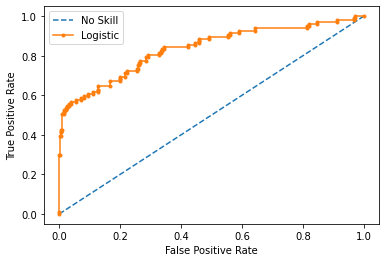

In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot
%matplotlib inline

test_predictions["Actual"] = np.where(test_predictions["Churn?"] == "True.", 1, 0)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_predictions["Actual"], [0 for _ in range(len(test_predictions["Churn?"]))])
lr_fpr, lr_tpr, _ = roc_curve(test_predictions["Actual"], test_predictions["Churn?.True."])

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

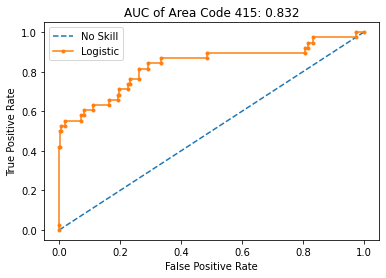

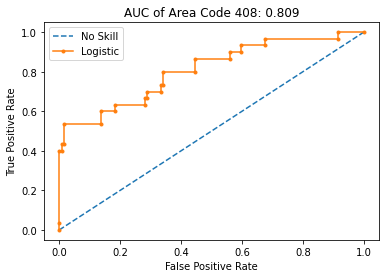

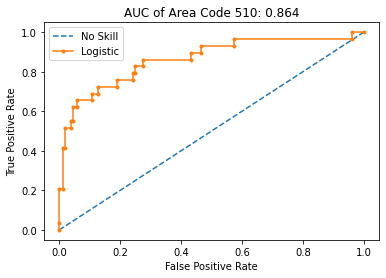

In [49]:
for ac in test_predictions["Area Code"].unique():
    grp = test_predictions[test_predictions["Area Code"] == ac]

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(grp["Actual"], [0 for _ in range(len(grp["Churn?"]))])
    lr_fpr, lr_tpr, _ = roc_curve(grp["Actual"], grp["Churn?.True."])

    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

    pyplot.title('AUC of Area Code ' + str(ac) + ': ' + str(round(auc(lr_fpr, lr_tpr), 3)))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

### Variable Importance

In [50]:
default_baseline.variable_importance()

gain,interaction,description
1,17_CVTE:CustServ Calls.0,"Out-of-fold mean of the response grouped by: ['CustServ Calls'] using 5 folds [internal:(10, 3, 10)]"
0.900773,1_CustServ Calls,CustServ Calls (Original)
0.873801,3_Day Charge,Day Charge (Original)
0.834801,14_VMail Message,VMail Message (Original)
0.777393,4_Day Mins,Day Mins (Original)
0.501504,7_Eve Mins,Eve Mins (Original)
0.455562,6_Eve Charge,Eve Charge (Original)
0.344162,8_Intl Calls,Intl Calls (Original)
0.32054,13_Night Mins,Night Mins (Original)
0.309224,12_Night Charge,Night Charge (Original)


### Retrain a Model for Production
* Retrain the final model with the full dataset
* Print the model metrics
* Create and Download the MOJO

In [51]:
dai.experiments.search_expert_settings("mojo")

make_mojo_scoring_pipeline | default_value: auto
mojo_for_predictions | default_value: auto
mojo_for_predictions_max_rows | default_value: 10000
mojo_for_predictions_batch_size | default_value: 100
mojo_acceptance_test_rtol | default_value: 0.0
mojo_acceptance_test_atol | default_value: 0.0
reduce_mojo_size | default_value: False
make_pipeline_visualization | default_value: auto
make_python_pipeline_visualization | default_value: auto
benchmark_mojo_latency | default_value: auto
benchmark_mojo_latency_auto_size_limit | default_value: 500
mojo_building_timeout | default_value: 1800.0
mojo_building_parallelism | default_value: -1
mojo_building_parallelism_base_model_size_limit | default_value: 100000000
pytorch_nlp_pretrained_models | default_value: ['bert-base-uncased', 'distilbert-base-uncased', 'bert-base-multilingual-cased']
included_pretransformers | default_value: []
enable_rulefit | default_value: auto
enable_rapids_cuml_models | default_value: False
enable_rapids_models_dask | de

In [ ]:
# Retrain on all data for productionalizing
full_model = default_baseline.retrain(final_pipeline_only=True, 
                                      train_dataset=telco_churn,
                                      test_dataset="",
                                      make_mojo_scoring_pipeline="on")

full_model = dai.experiments.get(full_model.key)

In [53]:
full_model.metrics()

{'scorer': 'F1',
 'val_score': 0.7113276492082826,
 'val_score_sd': 0.016703770755948092,
 'val_roc_auc': 0.8727579819113,
 'val_pr_auc': 0.7525046158060812,
 'test_score': None,
 'test_score_sd': None,
 'test_roc_auc': None,
 'test_pr_auc': None}

In [54]:
artifacts = full_model.artifacts.download("mojo_pipeline", './', overwrite=True)

Downloaded 'mojo.zip'


## Clean up

In [56]:
dai_engine.delete()